## Research Task - Incorporate feedback to Transit Performance Metrics Portfolio #1514

via Juan Matute
>If you're taking requests, I'd like to see the Table 8.1 performance metrics on a statewide basis, along with a 
>- list for each performance metric of which individual transit agency-mode of service combinations are 
>- in the bottom 5% (approximately two standard deviations from the mean) for each. 
>
>This would be illustrative for discussion purposes.


## Table 8.1
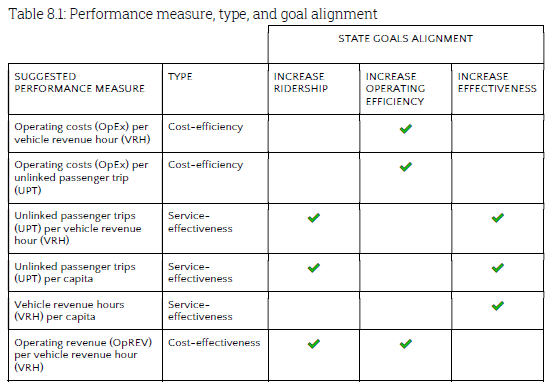

In [1]:
import altair as alt
import numpy as np
import pandas as pd
from new_transit_metrics_utils import GCS_FILE_PATH, make_long, sum_by_group

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
df = pd.read_parquet(f"{GCS_FILE_PATH}raw_transit_performance_metrics_data.parquet")

In [3]:
df.columns

Index(['agency_name', 'agency_status', 'city', 'mode', 'service', 'ntd_id',
       'reporter_type', 'reporting_module', 'state', 'primary_uza_name',
       'year', 'upt', 'vrh', 'vrm', 'opexp_total', 'RTPA', '_merge'],
      dtype='object')

In [4]:
df_agg = (
    df.groupby(["ntd_id", "city", "agency_name", "mode", "service"])
    .agg({"upt": "sum", "vrh": "sum", "vrm": "sum", "opexp_total": "sum"})
    .reset_index()
)

In [5]:
calc_dict = {
    "opex_per_vrh": ("opexp_total", "vrh"),
    "opex_per_vrm": ("opexp_total", "vrm"),
    "upt_per_vrh": ("upt", "vrh"),
    "upt_per_vrm": ("upt", "vrm"),
    "opex_per_upt": ("opexp_total", "upt"),
}

for new_col, (num, dem) in calc_dict.items():
    df_agg[new_col] = (df_agg[num] / df_agg[dem]).round(2)

# Dealing with NaN and inf values
Some of the metric calculation results in either inf or NaN values due to divide-by-zero scenarios. These values break the standard devatition calculation.

We will analyze the differences in standard deviation by filtering the data by these scenarios
1. remove rows with zeros
2. 
    1. upt_per_vrh/vrm NaN (0/0) values replaced with zero. Zero riders per revenue mile/hours still make sense. buses can still run and pick up zero passengers. highlights service ineffencies 
    2. opex_per_upt/vrm/vrh inf (#/0) values replaced with its opexp value. operating cost still exist even if nobody rides the bus. highlights cost inefficienies 
    3. opex_per_upt/vrm/vrh NaN (0/0) values replaced with zeros. not running the bus results in not picking up passengers and  zero operating cost.

In [6]:
# any rows with zero upt/vrh/vrm/opex?
no_zero_rows = df_agg[
    (df_agg["upt"] != 0)
    & (df_agg["vrh"] != 0)
    & (df_agg["vrm"] != 0)
    & (df_agg["opexp_total"] != 0)
]

In [7]:
replaced_values = df_agg.fillna(0)

# applying logic to alternate dataframe
col_list = ["opex_per_vrh", "opex_per_vrm", "opex_per_upt"]

for i in col_list:
    replaced_values[i] = replaced_values.apply(
        lambda row: row["opexp_total"] if row[i] == np.inf else row[i], axis=1
    )

In [8]:
display(len(df_agg), len(no_zero_rows), len(replaced_values))

412

401

412

## Overall Summary Statistics

In [21]:
display(no_zero_rows.columns, no_zero_rows.describe(), replaced_values.describe())

Index(['ntd_id', 'city', 'agency_name', 'mode', 'service', 'upt', 'vrh', 'vrm',
       'opexp_total', 'opex_per_vrh', 'opex_per_vrm', 'upt_per_vrh',
       'upt_per_vrm', 'opex_per_upt'],
      dtype='object')

upt           vrh           vrm   opexp_total  opex_per_vrh  \
count  4.010000e+02  4.010000e+02  4.010000e+02  4.010000e+02    401.000000   
mean   1.387393e+07  6.057536e+05  9.150192e+06  1.159269e+08    152.473890   
std    7.571695e+07  2.197522e+06  3.244346e+07  4.824113e+08    205.996039   
min    3.000000e+01  9.000000e+00  2.810000e+02  2.590000e+02     21.930000   
25%    9.960300e+04  2.597900e+04  3.275160e+05  2.757428e+06     83.280000   
50%    3.538580e+05  8.076900e+04  1.208917e+06  8.105467e+06    116.130000   
75%    2.716278e+06  3.188760e+05  5.037198e+06  4.053515e+07    150.660000   
max    1.249836e+09  3.490394e+07  4.351329e+08  6.949403e+09   2740.980000   

       opex_per_vrm  upt_per_vrh  upt_per_vrm  opex_per_upt  
count    401.000000   401.000000   401.000000    401.000000  
mean      11.755387     9.795536     0.785162     29.377781  
std       20.775520    13.854108     1.527742     24.157545  
min        0.520000     0.620000     0.050000      1.860000  
25%        5.960000     2.610000     0.180000     10.290000  
50%        8.580000     5.380000     0.370000     20.540000  
75%       12.000000    11.210000     0.780000     44.770000  
max      327.640000   122.010000    18.510000    119.070000

upt           vrh           vrm   opexp_total  opex_per_vrh  \
count  4.120000e+02  4.120000e+02  4.120000e+02  4.120000e+02  4.120000e+02   
mean   1.350351e+07  5.895806e+05  8.905891e+06  1.128427e+08  1.100033e+04   
std    7.473039e+07  2.170119e+06  3.204041e+07  4.762770e+08  1.376474e+05   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    8.945825e+04  2.438250e+04  2.847868e+05  2.550923e+06  8.314500e+01   
50%    3.397565e+05  7.177300e+04  1.094216e+06  7.698016e+06  1.166700e+02   
75%    2.503036e+06  3.082510e+05  4.838555e+06  3.968497e+07  1.534000e+02   
max    1.249836e+09  3.490394e+07  4.351329e+08  6.949403e+09  2.396004e+06   

       opex_per_vrm  upt_per_vrh  upt_per_vrm  opex_per_upt  
count  4.120000e+02   412.000000   412.000000  4.120000e+02  
mean   1.086337e+04     9.534005     0.764199  1.088052e+04  
std    1.376580e+05    13.758591     1.512478  1.376567e+05  
min    0.000000e+00     0.000000     0.000000  0.000000e+00  
25%    5.930000e+00     2.447500     0.170000  1.026500e+01  
50%    8.645000e+00     5.180000     0.350000  2.061000e+01  
75%    1.227500e+01    11.007500     0.752500  4.557500e+01  
max    2.396004e+06   122.010000    18.510000  2.396004e+06

In [22]:
# all metrics dict

all_metrics_x ={
    "bottom_upt_vrh": "upt_per_vrh",
    "bottom_upt_vrm": "upt_per_vrm",
    "bottom_opex_vrh": "opex_per_vrh",
    "bottom_opex_vrm": "opex_per_vrm",
    "bottom_opex_upt": "opex_per_upt",
}

all_metrics =[
    "upt_per_vrh",
    "upt_per_vrm",
    "opex_per_vrh",
    "opex_per_vrm",
    "opex_per_upt",
]

service_metrics_list = [
    "upt_per_vrh",
    "upt_per_vrm",
]

cost_metrics_list = [
    "opex_per_vrh",
    "opex_per_vrm",
    "opex_per_upt",
]

## Statewide Service-Effectiveness Metrics

In [43]:
for i in service_metrics_list:
    display(
    f"Statewide Bar Chart for {i}",
                
    # bar chart
    alt.Chart(no_zero_rows)
    .mark_bar()
    .encode(
        x=alt.X("agency_name:N", sort="-x"),
        y=i,
        tooltip=["agency_name:N", "mode", i],
        xOffset="mode:N",
    )
    .properties(
        title=f"All {i}",
        width="container",  # smaller width per facet
        height=200,
    ),
    
    f"Histogram Chart for {i}",
    # distribution plot
    alt.Chart(no_zero_rows).mark_bar().encode(
        alt.X(i).bin(maxbins=100),
            y="count()",
            tooltip=["count()"]
        ).properties(
        title = f"{i} Distribution",
        width="container",  # smaller width per facet
        height=200,
                    ),
    f"Heatmap Chart for {i}",    
    # heatmap
    alt.Chart(no_zero_rows)
        .mark_rect()
        .encode(
            x="agency_name",
            y="mode",
            color=i,
            tooltip= i,
        ).properties(title = f"{i} Heatmap").interactive()
            )


            # alt.Chart(no_zero_rows)
            # .mark_rect()
            # .encode(
            #     x = "agency_name",
            #     y = "mode",
            #     color = i
            # ),

            # no_zero_rows[
            #     ["agency_name", "city", "mode", "upt", "vrm", "vrh", i]
            # ].sort_values(by=i),
        

'Statewide Bar Chart for upt_per_vrh'

alt.Chart(...)

'Histogram Chart for upt_per_vrh'

alt.Chart(...)

'Heatmap Chart for upt_per_vrh'

alt.Chart(...)

'Statewide Bar Chart for upt_per_vrm'

alt.Chart(...)

'Histogram Chart for upt_per_vrm'

alt.Chart(...)

'Heatmap Chart for upt_per_vrm'

alt.Chart(...)

## Statewide Cost-Effecticeness Metrics

In [44]:
for i in cost_metrics_list:
            display(
    
    f"Statewide Bar Chart for {i}",
             
    # bar chart
    alt.Chart(no_zero_rows)
    .mark_bar()
    .encode(
        x=alt.X("agency_name:N", sort="-x"),
        y=i,
        tooltip=["agency_name:N", "mode", i],
        xOffset="mode:N",
    )
    .properties(
        title=f"All {i}",
        width="container",  # smaller width per facet
        height=200,
    ),
    
    f"Histogram Chart for {i}",

    # distribution plot
    alt.Chart(no_zero_rows).mark_bar().encode(
        alt.X(i).bin(maxbins=100),
            y="count()",
            tooltip=["count()"]
        ).properties(title = f"{i} Distribution",
                     width="container",  # smaller width per facet
        height=200,
                    ),
    f"Heatmap Chart for {i}",
    # heatmap
    alt.Chart(no_zero_rows)
        .mark_rect()
        .encode(
            x="agency_name",
            y="mode",
            color=i,
            tooltip= i,
        ).properties(title = f"{i} Heatmap").interactive()
            )


            # alt.Chart(no_zero_rows)
            # .mark_rect()
            # .encode(
            #     x = "agency_name",
            #     y = "mode",
            #     color = i
            # ),

            # no_zero_rows[
            #     ["agency_name", "city", "mode", "upt", "vrm", "vrh", i]
            # ].sort_values(by=i),
        

'Statewide Bar Chart for opex_per_vrh'

alt.Chart(...)

'Histogram Chart for opex_per_vrh'

alt.Chart(...)

'Heatmap Chart for opex_per_vrh'

alt.Chart(...)

'Statewide Bar Chart for opex_per_vrm'

alt.Chart(...)

'Histogram Chart for opex_per_vrm'

alt.Chart(...)

'Heatmap Chart for opex_per_vrm'

alt.Chart(...)

'Statewide Bar Chart for opex_per_upt'

alt.Chart(...)

'Histogram Chart for opex_per_upt'

alt.Chart(...)

'Heatmap Chart for opex_per_upt'

alt.Chart(...)

## Bottom 5% Service-effectiveness Metrics

In [12]:
# for the service metrics, higher is better. so look for the lowest
service_metrics = {
    "bottom_upt_vrh": "upt_per_vrh",
    "bottom_upt_vrm": "upt_per_vrm",
}

lowest_service_metrics = {}

# loop to populate dict with bottom 5% of the service metrics
for k, v in service_metrics.items():
    lowest_service_metrics[k] = no_zero_rows[
        no_zero_rows[v] <= no_zero_rows[v].quantile(0.05)
    ]

In [13]:
# loop to display the bottom 5% as dataframes
for k, v in lowest_service_metrics.items():
    print(f"\n Datset: {k}. Low service metrics are bad"),

    display(
        alt.Chart(v)
        .mark_bar()
        .encode(
            x=alt.X("agency_name", sort="y"),
            y=service_metrics[k],
            tooltip=["agency_name", "mode", service_metrics[k]],
        ).properties(title= f"Bottom 5% {service_metrics[k]}", width="container"),
        
        alt.Chart(v)
        .mark_rect()
        .encode(
            x="agency_name",
            y="mode",
            color=service_metrics[k]
        ),
        
        v[
            ["agency_name", "city", "mode", "upt", "vrm", "vrh", service_metrics[k]]
        ].sort_values(by=service_metrics[k]),
    )


 Datset: bottom_upt_vrh. Low service metrics are bad


alt.Chart(...)

alt.Chart(...)

agency_name            city  \
308  City of Calabasas (COC) - Public Works Departm...       Calabasas   
135     Central Contra Costa Transit Authority (CCCTA)         Concord   
400                 City of Escalon - Transit Services         Escalon   
170  Livermore / Amador Valley Transit Authority (L...       Livermore   
309  City of Carson - Transportation Services Division          Carson   
202            City of Union City (UCT) - Public Works      Union City   
374  City of West Hollywood (WEHO) - Business Devel...  West Hollywood   
365                    City of Rosemead - Public Works        Rosemead   
297       City of Bell - Community Services Department            Bell   
267                                  Paratransit, Inc.      Sacramento   
118            City of Commerce (CCT) - Transportation        Commerce   
149         Yolo County Transportation District (YCTD)        Woodland   
258  County of Sacramento Municipal Services Agency...      Sacramento   
36   Santa Clara Valley Transportation Authority (VTA)        San Jose   
228  County of Placer (PCT/TART) - Department of Pu...          Auburn   
386  City of Lakewood (DASH) - Recreation and Commu...        Lakewood   
247                           City of Elk Grove(etran)       Elk Grove   
304  City of Beverly Hills - Public Works - Transpo...   Beverly Hills   
257  City of Redondo Beach (BCT) - Transit Division...   Redondo Beach   
183  City of Lompoc (COLT) - Public Works/Transport...          Lompoc   
46               Alameda-Contra Costa Transit District         Oakland   

                mode      upt       vrm      vrh  upt_per_vrh  
308  Demand Response    14523     72173    23530         0.62  
135              Bus    17041    194414    15966         1.07  
400              Bus     5039    108377     4537         1.11  
170  Demand Response   146318   1309504   110483         1.32  
309              Bus     5926     41888     4485         1.32  
202  Demand Response    89614    327516    67479         1.33  
374  Demand Response    58365    218654    42857         1.36  
365  Demand Response    39940    209059    29108         1.37  
297  Demand Response    14658     54800    10694         1.37  
267  Demand Response    82352    952166    60245         1.37  
118  Demand Response    52374    391408    37970         1.38  
149  Demand Response   144189   1851119   104691         1.38  
258              Bus    17738    386861    12525         1.42  
36   Demand Response  1941330  21551055  1360251         1.43  
228              Bus    35604    415604    24827         1.43  
386  Demand Response    63681    365139    44467         1.43  
247  Demand Response    65813    501492    45410         1.45  
304  Demand Response    38988    109609    25669         1.52  
257  Demand Response    60264    293971    38950         1.55  
183  Demand Response    52390    200221    33659         1.56  
46   Demand Response  3004215  26985843  1929662         1.56


 Datset: bottom_upt_vrm. Low service metrics are bad


alt.Chart(...)

alt.Chart(...)

agency_name            city  \
258  County of Sacramento Municipal Services Agency...      Sacramento   
400                 City of Escalon - Transit Services         Escalon   
394  Stanislaus Council of Governments (StanCOG) - ...         Modesto   
96                      Riverside Transit Agency (RTA)       Riverside   
272   Imperial County Transportation Commission (ICTC)       El Centro   
151              City of Visalia (VT) - Transportation         Visalia   
95                      Riverside Transit Agency (RTA)       Riverside   
149         Yolo County Transportation District (YCTD)        Woodland   
139                             SunLine Transit Agency  Thousand Palms   
228  County of Placer (PCT/TART) - Department of Pu...          Auburn   
267                                  Paratransit, Inc.      Sacramento   
158  Metropolitan Transportation Commission (MTC) -...   San Francisco   
21           San Mateo County Transit District (SMCTD)      San Carlos   
76         San Diego Metropolitan Transit System (MTS)       San Diego   
54   Golden Gate Bridge, Highway and Transportation...   San Francisco   
36   Santa Clara Valley Transportation Authority (VTA)        San Jose   
30         San Joaquin Regional Transit District (RTD)        Stockton   
395            Madera County - Public Works Department          Madera   
135     Central Contra Costa Transit Authority (CCCTA)         Concord   
353     City of Malibu - Community Services Department          Malibu   
387  San Bernardino County Transportation Authority...  San Bernardino   
285                          Stanislaus County (StaRT)         Modesto   
263  Riverside County Transportation Commission (RCTC)       Riverside   
159  San Diego Association of Governments (SANDAG) ...       San Diego   
195                               Access Services (AS)        El Monte   
191  Los Angeles County Metropolitan Transportation...     Los Angeles   
180             Victor Valley Transit Authority (VVTA)        Hesperia   
130                     Monterey-Salinas Transit (MST)        Monterey   
87                North County Transit District (NCTD)       Oceanside   
77         San Diego Metropolitan Transit System (MTS)       San Diego   
22           San Mateo County Transit District (SMCTD)      San Carlos   
233  County of Placer (PCT/TART) - Department of Pu...          Auburn   
403                        San Joaquin Council (SJCOG)        Stockton   

                     mode       upt        vrm      vrh  upt_per_vrm  
258                   Bus     17738     386861    12525         0.05  
400                   Bus      5039     108377     4537         0.05  
394               Vanpool     52346     716703    14815         0.07  
96   Demand Response Taxi     25173     375038    13916         0.07  
272       Demand Response    126728    1562787    70560         0.08  
151          Commuter Bus    125615    1498297    39238         0.08  
95        Demand Response      8271      98596     4036         0.08  
149       Demand Response    144189    1851119   104691         0.08  
139               Vanpool    110958    1357521    25333         0.08  
228                   Bus     35604     415604    24827         0.09  
267       Demand Response     82352     952166    60245         0.09  
158               Vanpool   2999062   32490183   708723         0.09  
21        Demand Response    143132    1581576    54086         0.09  
76        Demand Response    171065    1804052    54744         0.09  
54        Demand Response    140278    1588391    86592         0.09  
36        Demand Response   1941330   21551055  1360251         0.09  
30        Demand Response     60135     698046    37354         0.09  
395          Commuter Bus    126187    1387497    47832         0.09  
135                   Bus     17041     194414    15966         0.09  
353  Demand Response Taxi      5287      53514     2866         0.10  
387               Vanpool    493283

## Bottom 5% Cost-effectiveness metrics

In [14]:
# for cost metrics, lower is better. so look for the highest
cost_metrics = {
    "bottom_opex_vrh": "opex_per_vrh",
    "bottom_opex_vrm": "opex_per_vrm",
    "bottom_opex_upt": "opex_per_upt",
}

highest_cost_metrics = {}

# loop to populate cost metrics dict, filters for greater than the 95th percentile (top 5% of the highest cost-metrics aka the top 5% worst cost-metrics)
for k, v in cost_metrics.items():
    highest_cost_metrics[k] = no_zero_rows[
        no_zero_rows[v] >= no_zero_rows[v].quantile(0.95)
    ]

In [15]:
# loop to display cost metrics DFs
for k, v in highest_cost_metrics.items():
    print(f"\n Datset: {k}. High cost metrics are bad"),
    display(
        alt.Chart(
            v#.sort_values(by=cost_metrics[k])
        )
        .mark_bar()
        .encode(
            x=alt.X(
                "agency_name", 
                sort="-y",
                scale=alt.Scale(paddingInner=0.1, paddingOuter=0.1
            )),
            y=alt.Y(
                cost_metrics[k], 
                #stack = None
            ),
            #color= "mode",
            xOffset="mode",
            tooltip=["agency_name", "mode", cost_metrics[k]],
        ).properties(title= f"Bottom 5% {cost_metrics[k]}",width="container"),
        alt.Chart(v)
        .mark_rect()
        .encode(
            x="agency_name",
            y="mode",
            color=cost_metrics[k]
        ),
        v[
            [
                "agency_name",
                "city",
                "mode",
                # "upt",
                "opexp_total",
                "vrm",
                "vrh",
                cost_metrics[k],
            ]
        ].sort_values(by=cost_metrics[k], ascending=False)
    )


 Datset: bottom_opex_vrh. High cost metrics are bad


alt.Chart(...)

alt.Chart(...)

agency_name           city  \
55   Golden Gate Bridge, Highway and Transportation...  San Francisco   
270  San Francisco Bay Area Water Emergency Transpo...  San Francisco   
88                North County Transit District (NCTD)      Oceanside   
225                    Altamont Corridor Express (ACE)       Stockton   
383    Sonoma-Marin Area Rail Transit District (SMART)       Petaluma   
184  Southern California Regional Rail Authority (S...    Los Angeles   
85                North County Transit District (NCTD)      Oceanside   
89                North County Transit District (NCTD)      Oceanside   
167      Peninsula Corridor Joint Powers Board (PCJPB)     San Carlos   
48   City and County of San Francisco (SFMTA) - Tra...  San Francisco   
40   Santa Clara Valley Transportation Authority (VTA)       San Jose   
86                North County Transit District (NCTD)      Oceanside   
190  Los Angeles County Metropolitan Transportation...    Los Angeles   
189  Los Angeles County Metropolitan Transportation...    Los Angeles   
51   City and County of San Francisco (SFMTA) - Tra...  San Francisco   
50   City and County of San Francisco (SFMTA) - Tra...  San Francisco   
3    San Francisco Bay Area Rapid Transit District ...        Oakland   
4    San Francisco Bay Area Rapid Transit District ...        Oakland   
53   Golden Gate Bridge, Highway and Transportation...  San Francisco   
65                Sacramento Regional Transit District     Sacramento   
187  Los Angeles County Metropolitan Transportation...    Los Angeles   

                              mode  opexp_total       vrm      vrh  \
55                      Ferryboats    195371304    948061    71278   
270                     Ferryboats    244756382   2324550   114069   
88                     Hybrid Rail     30335703    636450    28923   
225                  Commuter Rail    143295615   5573755   141171   
383                  Commuter Rail    163266006   4566095   176553   
184                  Commuter Rail   1475810477  72782609  1996532   
85                   Commuter Rail     36665200   1682633    52108   
89                     Hybrid Rail    115328092   3606463   164336   
167                  Commuter Rail    857551415  40264769  1243871   
48                       Cable Car    373274268   1139285   551837   
40                      Light Rail    732564335  17360305  1201700   
86                   Commuter Rail    114567302   6218660   188049   
190                     Light Rail   2559331040  91808996  4464909   
189                     Heavy Rail   1023656484  39094419  1814570   
51                       Streetcar    168319935   1845668   364561   
50                      Light Rail   1186464838  25477828  2818225   
3                      Hybrid Rail     81439438   5840831   198797   
4    Monorail / Automated Guideway     47048789   1839575   116589   
53                             Bus    426554859  18914052  1101718   
65                      Light Rail    459452176  23109296  1297840   
187              Bus Rapid Transit    194742634   9362002   599706   

     opex_per_vrh  
55        2740.98  
270       2145.69  
88        1048.84  
225       1015.05  
383        924.74  
184        739.19  
85         703.64  
89         701.78  
167        689.42  
48         676.42  
40         609.61  
86         609.24  
190        573.21  
189        564.13  
51         461.71  
50         421.00  
3          409.66  
4          403.54  
53         387.17  
65         354.01  
187        324.73


 Datset: bottom_opex_vrm. High cost metrics are bad


alt.Chart(...)

alt.Chart(...)

agency_name           city  \
48   City and County of San Francisco (SFMTA) - Tra...  San Francisco   
55   Golden Gate Bridge, Highway and Transportation...  San Francisco   
270  San Francisco Bay Area Water Emergency Transpo...  San Francisco   
51   City and County of San Francisco (SFMTA) - Tra...  San Francisco   
88                North County Transit District (NCTD)      Oceanside   
50   City and County of San Francisco (SFMTA) - Tra...  San Francisco   
40   Santa Clara Valley Transportation Authority (VTA)       San Jose   
52   City and County of San Francisco (SFMTA) - Tra...  San Francisco   
383    Sonoma-Marin Area Rail Transit District (SMART)       Petaluma   
89                North County Transit District (NCTD)      Oceanside   
363  City of Pico Rivera - Transit Division/Parks a...    Pico Rivera   
401                 City of Escalon - Transit Services        Escalon   
47   City and County of San Francisco (SFMTA) - Tra...  San Francisco   
109    City of Culver City - Transportation Department    Culver City   
43               Alameda-Contra Costa Transit District        Oakland   
190  Los Angeles County Metropolitan Transportation...    Los Angeles   
18           San Mateo County Transit District (SMCTD)     San Carlos   
359    City of Monterey Park - Public Works Department   Montery Park   
304  City of Beverly Hills - Public Works - Transpo...  Beverly Hills   
306  City of Burbank - Community Development-Transp...        Burbank   
189  Los Angeles County Metropolitan Transportation...    Los Angeles   

                  mode  opexp_total       vrm      vrh  opex_per_vrm  
48           Cable Car    373274268   1139285   551837        327.64  
55          Ferryboats    195371304    948061    71278        206.07  
270         Ferryboats    244756382   2324550   114069        105.29  
51           Streetcar    168319935   1845668   364561         91.20  
88         Hybrid Rail     30335703    636450    28923         47.66  
50          Light Rail   1186464838  25477828  2818225         46.57  
40          Light Rail    732564335  17360305  1201700         42.20  
52          Trolleybus   1082916887  26990327  4379827         40.12  
383      Commuter Rail    163266006   4566095   176553         35.76  
89         Hybrid Rail    115328092   3606463   164336         31.98  
363    Demand Response      2757428     88212    10848         31.26  
401    Demand Response       414872     13471     2797         30.80  
47                 Bus   2378676460  77885693  9948289         30.54  
109    Demand Response      1977024     67512     7642         29.28  
43   Bus Rapid Transit     57224517   1981875   229273         28.87  
190         Light Rail   2559331040  91808996  4464909         27.88  
18                 Bus    697324490  25163733  2565362         27.71  
359    Demand Response      3502588    126953    16423         27.59  
304    Demand Response      2926879    109609    25669         26.70  
306    Demand Response      4993412    188609    24699         26.47  
189         Heavy Rail   1023656484  39094419  1814570         26.18


 Datset: bottom_opex_upt. High cost metrics are bad


alt.Chart(...)

alt.Chart(...)

agency_name             city  \
258  County of Sacramento Municipal Services Agency...       Sacramento   
400                 City of Escalon - Transit Services          Escalon   
30         San Joaquin Regional Transit District (RTD)         Stockton   
118            City of Commerce (CCT) - Transportation         Commerce   
352     City of Malibu - Community Services Department           Malibu   
363  City of Pico Rivera - Transit Division/Parks a...      Pico Rivera   
309  City of Carson - Transportation Services Division           Carson   
135     Central Contra Costa Transit Authority (CCCTA)          Concord   
247                           City of Elk Grove(etran)        Elk Grove   
249  San Luis Obispo Regional Transit Authority (SL...  San Luis Obispo   
149         Yolo County Transportation District (YCTD)         Woodland   
155  City of Fairfield, California - Transportation...        Fairfield   
87                North County Transit District (NCTD)        Oceanside   
324              City of Downey - Parks and Recreation           Downey   
308  City of Calabasas (COC) - Public Works Departm...        Calabasas   
267                                  Paratransit, Inc.       Sacramento   
9     Santa Cruz Metropolitan Transit District (SCMTD)       Santa Cruz   
20           San Mateo County Transit District (SMCTD)       San Carlos   
228  County of Placer (PCT/TART) - Department of Pu...           Auburn   
231  County of Placer (PCT/TART) - Department of Pu...           Auburn   
46               Alameda-Contra Costa Transit District          Oakland   

                mode  opexp_total       vrm      vrh  opex_per_upt  
258              Bus      2111992    386861    12525        119.07  
400              Bus       561996    108377     4537        111.53  
30   Demand Response      6429192    698046    37354        106.91  
118  Demand Response      5193408    391408    37970         99.16  
352  Demand Response       352215     33085     1717         96.60  
363  Demand Response      2757428     88212    10848         96.55  
309              Bus       565380     41888     4485         95.41  
135              Bus      1613133    194414    15966         94.66  
247  Demand Response      6020046    501492    45410         91.47  
249  Demand Response     22220249   2246041   154069         88.72  
149  Demand Response     12558635   1851119   104691         87.10  
155  Demand Response      7733564    779472    50909         86.90  
87   Demand Response     59885103   6830189   402386         85.99  
324  Demand Response      5324483    233720    26568         85.39  
308  Demand Response      1224003     72173    23530         84.28  
267  Demand Response      6815173    952166    60245         82.76  
9    Demand Response     31232200   2311554   218086         81.52  
20   Demand Response     88981786   8964157   704575         79.64  
228              Bus      2782686    415604    24827         78.16  
231  Demand Response       329980     26987     1083         77.28  
46   Demand Response    231425414  26985843  1929662         77.03

In [16]:
no_zero_rows.columns

Index(['ntd_id', 'city', 'agency_name', 'mode', 'service', 'upt', 'vrh', 'vrm',
       'opexp_total', 'opex_per_vrh', 'opex_per_vrm', 'upt_per_vrh',
       'upt_per_vrm', 'opex_per_upt'],
      dtype='object')

In [17]:
alt.Chart(no_zero_rows).transform_fold(
    ['opex_per_vrh', 'opex_per_vrm', 'upt_per_vrh','upt_per_vrm', 'opex_per_upt'], as_= ["Performance Metric", "Value"]
    ).mark_bar(
        opacity = 0.3,
        binSpacing=0
    ).encode(
        alt.X("Value:Q").bin(maxbins=10),
        alt.Y("count()").stack(None),
        alt.Color("Performance Metric:N")
    )

alt.Chart(...)

In [18]:
for i in calc_dict.keys():
    display(
        alt.Chart(no_zero_rows).mark_bar().encode(
            alt.X(i).bin(maxbins=100),
            y="count()",
            tooltip=["count()"]
        ).properties(title = i),
        
       #  alt.Chart(no_zero_rows).transform_fold(
       #      ['opex_per_vrh', 'opex_per_vrm', 'upt_per_vrh',
       # 'upt_per_vrm', 'opex_per_upt'], as_=["Performance Metric", "Value"]
       #  ).mark_bar(
       #      opacity = 0.3,
       #      binSpacing=0
       #  ).encode(
       #      alt.X("Value:Q").bin(maxbins=100),
       #      alt.Y("count()").stack(None),
       #      alt.Color("Performance Metrics:N")
       #  ),
        
        alt.Chart(no_zero_rows).mark_rect().encode(
        x="agency_name",
        y="mode",
        color = i,)
        .properties(title = i),
            )

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

---

In [19]:
# who are are bottom 5% in each metrics
bottom_metrics = {
    "bottom_opex_vrh": "opex_per_vrh",
    "bottom_opex_vrm": "opex_per_vrm",
    "bottom_opex_upt": "opex_per_upt",
    "bottom_upt_vrh": "upt_per_vrh",
    "bottom_upt_vrm": "upt_per_vrm",
}
bottom_5 = {}
for k, v in bottom_metrics.items():
    bottom_5[k] = no_zero_rows[no_zero_rows[v] <= no_zero_rows[v].quantile(0.05)]

In [20]:
for k, v in bottom_5.items():
    print(f"\n Datset: {k}"),
    display(
        v[
            [
                "agency_name",
                "mode",
                "upt",
                "vrm",
                "vrh",
                "opexp_total",
                bottom_metrics[k],
            ]
        ].sort_values(by=bottom_metrics[k])
    )


 Datset: bottom_opex_vrh


agency_name                  mode  \
159  San Diego Association of Governments (SANDAG) ...               Vanpool   
191  Los Angeles County Metropolitan Transportation...               Vanpool   
403                        San Joaquin Council (SJCOG)               Vanpool   
158  Metropolitan Transportation Commission (MTC) -...               Vanpool   
394  Stanislaus Council of Governments (StanCOG) - ...               Vanpool   
107      Orange County Transportation Authority (OCTA)               Vanpool   
402                 City of Escalon - Transit Services       Demand Response   
242     Kings County Area Public Transit Agency (KART)               Vanpool   
379     San Luis Obispo Council of Governments(SLOCOG)               Vanpool   
387  San Bernardino County Transportation Authority...               Vanpool   
133                     Monterey-Salinas Transit (MST)               Vanpool   
278                 California Vanpool Authority (CVA)               Vanpool   
180             Victor Valley Transit Authority (VVTA)               Vanpool   
263  Riverside County Transportation Commission (RCTC)               Vanpool   
334  City of Huntington Park (HPCA) - Fixed Route T...  Demand Response Taxi   
25         City of Torrance (TTS) - Transit Department  Demand Response Taxi   
13                               City of Modesto (MAX)  Demand Response Taxi   
353     City of Malibu - Community Services Department  Demand Response Taxi   
37   Santa Clara Valley Transportation Authority (VTA)       Demand Response   
369     City of South Gate - Transportation Department  Demand Response Taxi   
206         The Eastern Contra Costa Transit Authority  Demand Response Taxi   

          upt        vrm      vrh  opexp_total  opex_per_vrh  
159   7758304   78255030  1842088     40397435         21.93  
191  13083672  130179437  3241387     75197780         23.20  
403   2671031   27902940   650385     16410211         25.23  
158   2999062   32490183   708723     18340241         25.88  
394     52346     716703    14815       387383         26.15  
107   4184679   31769675   865540     22842318         26.39  
402        30        281        9          259         28.78  
242    350906    1936208    39486      1156393         29.29  
379     77266     643071    12149       373287         30.73  
387    493283    5164178   128633      3982640         30.96  
133     42559     310052     7019       224880         32.04  
278  20883232   61687512  2074368     67053763         32.32  
180   3015548   30138660   616249     20820021         33.79  
263    528595    5040551   126908      4325683         34.09  
334     54997     103002    10370       403594         38.92  
25     114370     449082    21865       919277         42.04  
13       9586      38429     3869       164167         42.43  
353      5287      53514     2866       122091         42.60  
37      65395     565986    37869      1657998         43.78  
369    288814     369848    24659      1082726         43.91  
206     40235     280052     9919       440600         44.42


 Datset: bottom_opex_vrm


agency_name                  mode  \
159  San Diego Association of Governments (SANDAG) ...               Vanpool   
394  Stanislaus Council of Governments (StanCOG) - ...               Vanpool   
158  Metropolitan Transportation Commission (MTC) -...               Vanpool   
191  Los Angeles County Metropolitan Transportation...               Vanpool   
379     San Luis Obispo Council of Governments(SLOCOG)               Vanpool   
403                        San Joaquin Council (SJCOG)               Vanpool   
242     Kings County Area Public Transit Agency (KART)               Vanpool   
180             Victor Valley Transit Authority (VVTA)               Vanpool   
107      Orange County Transportation Authority (OCTA)               Vanpool   
133                     Monterey-Salinas Transit (MST)               Vanpool   
387  San Bernardino County Transportation Authority...               Vanpool   
263  Riverside County Transportation Commission (RCTC)               Vanpool   
402                 City of Escalon - Transit Services       Demand Response   
278                 California Vanpool Authority (CVA)               Vanpool   
233  County of Placer (PCT/TART) - Department of Pu...               Vanpool   
139                             SunLine Transit Agency               Vanpool   
206         The Eastern Contra Costa Transit Authority  Demand Response Taxi   
299       City of Bell - Community Services Department  Demand Response Taxi   
25         City of Torrance (TTS) - Transit Department  Demand Response Taxi   
259  County of Sacramento Municipal Services Agency...          Commuter Bus   
205         The Eastern Contra Costa Transit Authority       Demand Response   

          upt        vrm      vrh  opexp_total  opex_per_vrm  
159   7758304   78255030  1842088     40397435          0.52  
394     52346     716703    14815       387383          0.54  
158   2999062   32490183   708723     18340241          0.56  
191  13083672  130179437  3241387     75197780          0.58  
379     77266     643071    12149       373287          0.58  
403   2671031   27902940   650385     16410211          0.59  
242    350906    1936208    39486      1156393          0.60  
180   3015548   30138660   616249     20820021          0.69  
107   4184679   31769675   865540     22842318          0.72  
133     42559     310052     7019       224880          0.73  
387    493283    5164178   128633      3982640          0.77  
263    528595    5040551   126908      4325683          0.86  
402        30        281        9          259          0.92  
278  20883232   61687512  2074368     67053763          1.09  
233     75076     766441    17323       985917          1.29  
139    110958    1357521    25333      1802204          1.33  
206     40235     280052     9919       440600          1.57  
299     13308      32966     1290        58055          1.76  
25     114370     449082    21865       919277          2.05  
259    211251    1484677    52737      3089962          2.08  
205    126838     855799    31082      1786715          2.09


 Datset: bottom_opex_upt


agency_name                  mode  \
252               Anaheim Transportation Network (ATN)                   Bus   
168  University of California, Davis (ASUCD) - Asso...                   Bus   
355        City of Maywood (COM) - City Manager Office                   Bus   
319                               City of Cudahy (COC)                   Bus   
343  Los Angeles County (LACDPW) - Department of Pu...                   Bus   
78         San Diego Metropolitan Transit System (MTS)            Light Rail   
278                 California Vanpool Authority (CVA)               Vanpool   
242     Kings County Area Public Transit Agency (KART)               Vanpool   
340  Los Angeles County - Department of Public Work...                   Bus   
369     City of South Gate - Transportation Department  Demand Response Taxi   
291              City of Alhambra (ACT) - Public Works                   Bus   
73         San Diego Metropolitan Transit System (MTS)                   Bus   
160  City of Laguna Beach (CLB) - Transit and Commu...                   Bus   
299       City of Bell - Community Services Department  Demand Response Taxi   
379     San Luis Obispo Council of Governments(SLOCOG)               Vanpool   
325                                     City of Duarte                   Bus   
345  Los Angeles County - Department of Public Work...                   Bus   
52   City and County of San Francisco (SFMTA) - Tra...            Trolleybus   
406                         City of Pasadena - Transit                   Bus   
47   City and County of San Francisco (SFMTA) - Tra...                   Bus   
300                City of Bell Gardens - public works                   Bus   

           upt       vrm      vrh  opexp_total  opex_per_upt  
252   40298090   6035251   914722     74888453          1.86  
168   15984579   4217438   396861     40189006          2.51  
355     508041    180862    17032      1416681          2.79  
319     398706    204207    20796      1157310          2.90  
343     976387    344242    39341      2863269          2.93  
78   191595181  61092178  3360018    604991455          3.16  
278   20883232  61687512  2074368     67053763          3.21  
242     350906   1936208    39486      1156393          3.30  
340    3280207   1417870   172903     11184219          3.41  
369     288814    369848    24659      1082726          3.75  
291    1612230    997862    96829      6275377          3.89  
73   110837372  63660311  6248660    453352279          4.09  
160    2301955   1003414   116803      9623267          4.18  
299      13308     32966     1290        58055          4.36  
379      77266    643071    12149       373287          4.83  
325     273107    140882    11738      1328165          4.86  
345     319072    180719    19672      1564654          4.90  
52   220737578  26990327  4379827   1082916887          4.91  
406    7376352   4249882   410477     36772814          4.99  
47   475941074  77885693  9948289   2378676460          5.00  
300     663121    582414    55838      3341973          5.04


 Datset: bottom_upt_vrh


agency_name             mode  \
308  City of Calabasas (COC) - Public Works Departm...  Demand Response   
135     Central Contra Costa Transit Authority (CCCTA)              Bus   
400                 City of Escalon - Transit Services              Bus   
170  Livermore / Amador Valley Transit Authority (L...  Demand Response   
309  City of Carson - Transportation Services Division              Bus   
202            City of Union City (UCT) - Public Works  Demand Response   
374  City of West Hollywood (WEHO) - Business Devel...  Demand Response   
365                    City of Rosemead - Public Works  Demand Response   
297       City of Bell - Community Services Department  Demand Response   
267                                  Paratransit, Inc.  Demand Response   
118            City of Commerce (CCT) - Transportation  Demand Response   
149         Yolo County Transportation District (YCTD)  Demand Response   
258  County of Sacramento Municipal Services Agency...              Bus   
36   Santa Clara Valley Transportation Authority (VTA)  Demand Response   
228  County of Placer (PCT/TART) - Department of Pu...              Bus   
386  City of Lakewood (DASH) - Recreation and Commu...  Demand Response   
247                           City of Elk Grove(etran)  Demand Response   
304  City of Beverly Hills - Public Works - Transpo...  Demand Response   
257  City of Redondo Beach (BCT) - Transit Division...  Demand Response   
183  City of Lompoc (COLT) - Public Works/Transport...  Demand Response   
46               Alameda-Contra Costa Transit District  Demand Response   

         upt       vrm      vrh  opexp_total  upt_per_vrh  
308    14523     72173    23530      1224003         0.62  
135    17041    194414    15966      1613133         1.07  
400     5039    108377     4537       561996         1.11  
170   146318   1309504   110483      6550101         1.32  
309     5926     41888     4485       565380         1.32  
202    89614    327516    67479      6616203         1.33  
374    58365    218654    42857      3946471         1.36  
365    39940    209059    29108      2373266         1.37  
297    14658     54800    10694       616863         1.37  
267    82352    952166    60245      6815173         1.37  
118    52374    391408    37970      5193408         1.38  
149   144189   1851119   104691     12558635         1.38  
258    17738    386861    12525      2111992         1.42  
36   1941330  21551055  1360251    126678726         1.43  
228    35604    415604    24827      2782686         1.43  
386    63681    365139    44467      3598971         1.43  
247    65813    501492    45410      6020046         1.45  
304    38988    109609    25669      2926879         1.52  
257    60264    293971    38950      3935795         1.55  
183    52390    200221    33659      3547329         1.56  
46   3004215  26985843  1929662    231425414         1.56


 Datset: bottom_upt_vrm


agency_name                  mode  \
258  County of Sacramento Municipal Services Agency...                   Bus   
400                 City of Escalon - Transit Services                   Bus   
394  Stanislaus Council of Governments (StanCOG) - ...               Vanpool   
96                      Riverside Transit Agency (RTA)  Demand Response Taxi   
272   Imperial County Transportation Commission (ICTC)       Demand Response   
151              City of Visalia (VT) - Transportation          Commuter Bus   
95                      Riverside Transit Agency (RTA)       Demand Response   
149         Yolo County Transportation District (YCTD)       Demand Response   
139                             SunLine Transit Agency               Vanpool   
228  County of Placer (PCT/TART) - Department of Pu...                   Bus   
267                                  Paratransit, Inc.       Demand Response   
158  Metropolitan Transportation Commission (MTC) -...               Vanpool   
21           San Mateo County Transit District (SMCTD)       Demand Response   
76         San Diego Metropolitan Transit System (MTS)       Demand Response   
54   Golden Gate Bridge, Highway and Transportation...       Demand Response   
36   Santa Clara Valley Transportation Authority (VTA)       Demand Response   
30         San Joaquin Regional Transit District (RTD)       Demand Response   
395            Madera County - Public Works Department          Commuter Bus   
135     Central Contra Costa Transit Authority (CCCTA)                   Bus   
353     City of Malibu - Community Services Department  Demand Response Taxi   
387  San Bernardino County Transportation Authority...               Vanpool   
285                          Stanislaus County (StaRT)          Commuter Bus   
263  Riverside County Transportation Commission (RCTC)               Vanpool   
159  San Diego Association of Governments (SANDAG) ...               Vanpool   
195                               Access Services (AS)       Demand Response   
191  Los Angeles County Metropolitan Transportation...               Vanpool   
180             Victor Valley Transit Authority (VVTA)               Vanpool   
130                     Monterey-Salinas Transit (MST)          Commuter Bus   
87                North County Transit District (NCTD)       Demand Response   
77         San Diego Metropolitan Transit System (MTS)  Demand Response Taxi   
22           San Mateo County Transit District (SMCTD)  Demand Response Taxi   
233  County of Placer (PCT/TART) - Department of Pu...               Vanpool   
403                        San Joaquin Council (SJCOG)               Vanpool   

          upt        vrm      vrh  opexp_total  upt_per_vrm  
258     17738     386861    12525      2111992         0.05  
400      5039     108377     4537       561996         0.05  
394     52346     716703    14815       387383         0.07  
96      25173     375038    13916       977605         0.07  
272    126728    1562787    70560      9269302         0.08  
151    125615    1498297    39238      4157292         0.08  
95       8271      98596     4036       218632         0.08  
149    144189    1851119   104691     12558635         0.08  
139    110958    1357521    25333      1802204         0.08  
228     35604     415604    24827      2782686         0.09  
267     82352     952166    60245      6815173         0.09  
158   2999062   32490183   708723     18340241         0.09  
21     143132    1581576    54086      8726637         0.09  
76     171065    1804052    54744      5971350         0.09  
54     140278    1588391    86592     10293673         0.09  
36    1941330   21551055  1360251    126678726         0.09  
30      60135     698046    37354      6429192         0.09  
395    126187    1387497    47832      4879036         0.09  
135     17041     194414    15966      1613133         0.09  
353      5287      53514     2866       122091         0.10  
387    493283    516